<a href="https://colab.research.google.com/github/andygoosh/samsung/blob/master/workinprogress.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from pathlib import Path
from google.colab import files, drive
from collections import defaultdict

import re
import random as rn
import pandas as pd
import numpy as np
from numpy import array, argmax, random, take
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline

from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, Model
from keras.layers import Input, Dropout, Dense, LSTM, GRU, Embedding, RepeatVector, TimeDistributed
from keras.layers import Bidirectional as Bi
from keras import optimizers
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping

RS = 77
rn.seed(RS)
# tf.random.set_seed(RS)
np.random.seed(RS)
np.random.RandomState(RS)

gpath = Path('/content/gdrive')
drive.mount(str(gpath))
data_file = gpath / 'My Drive/Samsung' / 'transcriptions'

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


#### Let's look at the data in given file

In [2]:
with data_file.open() as f:  
    print(list(f.readline()))

['а', 'у', 'к', 'ц', 'и', 'о', 'н', 'ы', ' ', 'н', 'а', ' ', 'д', 'е', 'ш', 'ё', 'в', 'о', 'е', ' ', 'ж', 'и', 'л', 'ь', 'ё', ' ', 'п', 'р', 'о', 'в', 'о', 'д', 'я', 'т', 'с', 'я', ' ', 'р', 'е', 'г', 'у', 'л', 'я', 'р', 'н', 'о', '\t', '%', '%', ' ', 'a', ' ', 'u', ' ', 'k', ' ', 't', 's', ' ', 'y', ' ', 'o', '1', ' ', 'n', ' ', 'a', 'x', ' ', '#', ' ', 'n', ' ', 'a', 'x', "'", ' ', '_', ' ', 'd', "'", ' ', "'", 'i', ' ', 's', 'h', ' ', 'o', '1', ' ', 'v', ' ', 'a', 'x', "'", ' ', 'j', 'a', 'x', ' ', '#', ' ', 'z', 'h', ' ', 'y', "'", ' ', 'l', "'", ' ', 'j', "'", ' ', "'", 'o', '1', ' ', '#', ' ', 'p', ' ', 'r', ' ', 'a', ' ', 'v', ' ', 'o', "'", '1', ' ', 'd', "'", ' ', "'", 'a', 'x', ' ', 't', 's', ' ', 't', 's', ' ', 'a', 'x', "'", ' ', '#', ' ', 'r', "'", ' ', "'", 'i', 'x', ' ', 'g', ' ', 'u', "'", ' ', 'l', "'", ' ', "'", 'a', '1', ' ', 'r', ' ', 'n', ' ', 'a', ' ', '%', '%', '\n']


#### Notice that:
1. russian sentence is separated from transcript with '\t'
2. the begining and the end of transcript part are marked by '%%'

### Let's read the data and split it into rus and trans

In [4]:
rus_trn = []
with data_file.open() as f:  
  for line in f: 
    rus, trn = line.split('\t')
    rus_trn.append([rus.strip(), trn.strip()])

print(f'Number of sentences in corpus: {len(rus_trn)}')

Number of sentences in corpus: 50277


##### Let's look at some sentences


In [5]:
a,b,c = np.random.choice(len(rus_trn), 3)

print(rus_trn[a][0])
print(rus_trn[a][1])
print(rus_trn[b][0])
print(rus_trn[b][1])
print(rus_trn[c][0])
print(rus_trn[c][1])

веб-операторы обязаны ознакомить пользователя с политикой по сбору персональной информации
%% v' 'e1 p a' p' 'i r a1 t ax r ax # a' b' 'a1 z ax n ax # a z n a k o'1 m' 'ix' t' # p o'1 l' z ax v ax' t' 'ix' l' 'ax # s _ p a' l' 'i'1 t' 'ix k ax' j' # p a _ z b o1 r ux' # p' 'ix r s a n a'1 l' n ax' j' # 'i n f a r m a1 ts ax' i %%
цена мартовского контракта на нефть в торговой системе поднялась
%% ts y n a1 # m a1 r t ax f s k ax v ax # k a n t r a1 k t ax # n a' _ n' 'e1 f t' # f _ t a r g o1 v ax' j' # s' 'i' s' t' 'e'1 m' 'ix # p ax' d' n' 'i l a'1 s' %%
в августе прошлого года был достроен храм христа спасителя
%% v _ a1 v g ux' s' t' 'ix # p r o1 sh l ax v ax # g o1 d ax # b y1 l # d a s t r o'1 jax n # h r a1 m # h r' 'i s t a1 # s p a' s' 'i'1 t' 'ix' l' 'a %%


#### Notice that words in russian sentence are separated by space while words in transcript are separated:
1. by '#' in general case
2. by '_' in case of preposition
3. by '%% %%' in case of punctuation signs (dash, coma, etc)


#### Let's see if we have dupliates in corpus

In [5]:
a = array(rus_trn)
seen_rus = Counter(a[:,0])
seen_trn = Counter(a[:,1])

print(f'Unique rus sentences: {len(seen_rus)} out of {len(rus_trn)}')
print(f'Unique trans sentences: {len(seen_trn)} out of {len(rus_trn)}')

Unique rus sentences: 3131 out of 50277
Unique trans sentences: 3171 out of 50277


#### We have a lot of duplicates! Only 3131 unique sentenses out of 50K in corpus. Please also note that some russian sentences are transcribed into different transcriptions (will look into that later on)

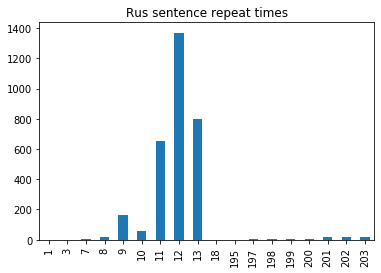

In [6]:
lens = [each[1] for each in seen_rus.items()]
unq = np.unique(lens)
qty = [lens.count(each) for each in unq]
pd.DataFrame(qty, index=unq).plot.bar(title = 'Rus sentence repeat times', legend=False);

#### Most duplicated sentences repeat 12 times, max up to 203 times

### Let's read that data while splitting the tokens. We'll count the tokens in each sentence. If the count in rus and trans is different, we'll record it as anomaly


Anomalies: 49


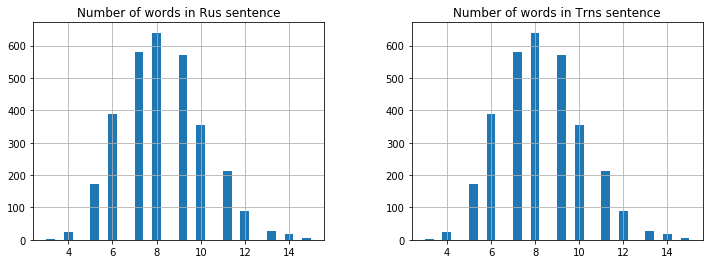

In [7]:
rus_l, trn_l, anomaly = [], [], []
seen = defaultdict(list)
chars = Counter()

for j,i in enumerate(rus_trn):
  rus = i[0].split()
  trn = re.split('#|_|%% %%',i[1])

  if i[0] not in seen:
    if abs(len(rus) - len(trn)) != 0: 
      anomaly.append(j)
      # print(j, ' ', i[0])
      # print( i[1])
    
    else:
      rus_l.append(len(rus))
      trn_l.append(len(trn))

    chars += Counter(i[0])

  seen[i[0]].append(j)

print(f'Anomalies: {len(anomaly)}')
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2,figsize=(12,4))
pd.DataFrame({'Number of words in Rus sentence':rus_l}).hist(ax=ax1, bins = 30);
pd.DataFrame({'Number of words in Trns sentence':trn_l}).hist(ax=ax2, bins = 30);

#### So we have 49 anomalies out of 3131 samples

### Let's see if we need to clean the data. First let's take a look at rus corpus alphabet

Number of times "-" used: 159


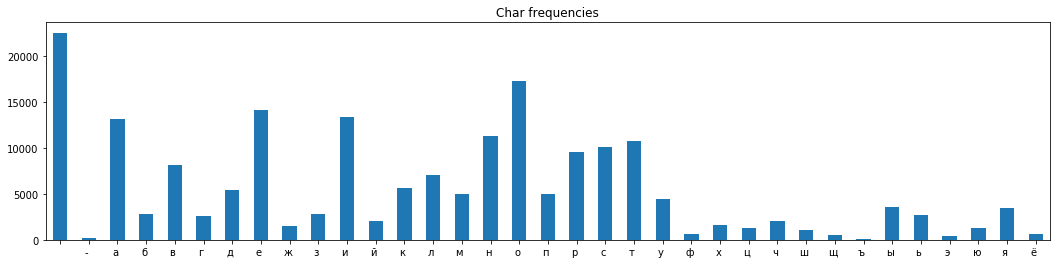

In [8]:
s = sorted(chars.items())
pd.DataFrame(s, index=(e[0]+' ' for e in s)).plot.bar(figsize=(18,4), rot=0, title = 'Char frequencies', legend=False)
print(f'Number of times "-" used: {chars["-"]}')

#### Looks good! We neither have punctuations nor capital letters. The only case to check is '-' letter which is used 159 times

In [9]:
seen = set()
seen_dash = set()
dash_words = []
for rus,trn in rus_trn:
  if rus not in seen:
    if '-' in rus:
      ru_words = rus.split()
      for each in ru_words:
        if '-' in each:
          if each not in seen_dash:
            seen_dash.add(each)
            dash_words.append(each)
  else:
    seen.add(rus)
  
print(dash_words)

['анти-обледенитель', 'иридо-диагностика', 'дом-красавец', 'из-за', 'радио-сигналом', 'ноль-три', 'ноль-два', 'мало-обеспеченные', 'шкаф-купе', 'тех-осмотр', 'пресс-службе', 'авто-сервис', 'чуть-чуть', 'аудио-', 'какие-либо', 'де-факто', 'стерео-', 'царь-колокол', 'царь-пушка', 'гео-магнитного', 'электро-катастрофы', 'фигуристы-новобранцы', 'что-то', 'какое-либо', 'веб-операторы', 'воздушно-десантной', 'военно-морских', 'ветераны-афганцы', 'одного-единственного', 'природно-климатические', 'одном-двух', 'санкт-петербурге', 'стран-участниц', 'пять-шесть', 'по-своему', 'матч-реванш', 'словаря-справочника', 'штаб-квартире', 'чем-то', 'чего-то', 'экс-губернатора', 'российско-американский', 'северо-восточных', 'красно-белую', 'какой-нибудь', 'бело-жёлтый', 'карту-схему', 'юго-западный', 'радио-охранное', 'по-прежнему', 'каким-то', 'кино-картины', 'авто-трюки', 'пресс-конференции', 'генерал-прокурором', 'нью-йорке', 'медиа-группы', 'нью-йоркской', 'какие-то', 'санкт-петербурга', 'санкт-петерб

#### Okey, words with dash look fine, we'll consider dash as a normal letter

### So in order to implement autocoder for transcript we'd need to keep special symbools in transcript such as "\_" and "%% %%". So let's create a dictionary of sentences rus <-> trans. So let's recreate the dictionary so "\_" and "%% %%" are marked with '#' and remove begin and end markers. Plus to that let's get rid of duplicates.


In [0]:
# !pip3 install transliterate
# from transliterate import translit
# translit('длавды дылпадыал лыдап', 'ru', reversed=True)

max len rus: 27, max len trn: 26


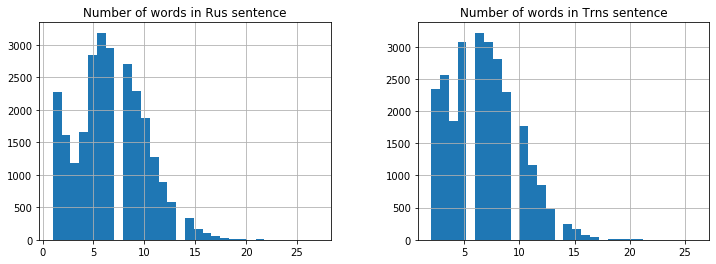

In [55]:
seen_rus = set()
seen_trn = set()

res, trn_l, rus_l = [], [], []
for rus, trn in rus_trn:

  if rus not in seen_rus or trn not in seen_trn:
      seen_rus.add(rus)
      seen_trn.add(trn)

      # trn = trn.replace('%% %%', '%% %% #').replace('_', '_ #')[3:-3]
      # trn = trn.split(' ')
      # rus_l.append( len(rus))
      # trn_l.append( len(trn))
      # res.append([list(rus), trn, trn])

      trn = trn.replace('%% %%', '#').replace('_', '_ #')[3:-3]
      trn = trn.split('#')
      rus = rus.split(' ')
      for a,b in zip(rus, trn):
        b = b.strip().split(' ')
        res.append((list(a), b + ['<eos>'], ['<sos>'] + b))
        rus_l.append( len(a))
        trn_l.append( len(b))

      # trn = trn.replace('%% %%', '# %% %%').replace('_', '_ #')[2:-2]
      # trn = trn.split('#')
      # rus = rus.split()

      # rus_l.append( len(rus))
      # trn_l.append( len(trn)+2)
      # res.append([rus, ['<sos>'] + trn + ['<eos>'], ['<sos>'] + trn + ['<eos>']])

rus_trn_new = array(res)
trn_length = max(trn_l)
rus_length = max(rus_l)
print(f'max len rus: {rus_length}, max len trn: {trn_length}')
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2,figsize=(12,4))
pd.DataFrame({'Number of words in Rus sentence':rus_l}).hist(ax=ax1, bins = 30);
pd.DataFrame({'Number of words in Trns sentence':trn_l}).hist(ax=ax2, bins = 30);

In [56]:
a = np.random.choice(len(rus_trn_new))
rus_trn_new[a]

array([list(['п', 'о', 'я', 'в', 'л', 'е', 'н', 'и', 'я']),
       list(['p', "ax'", 'ji', 'v', "l'", "'e'1", "n'", "'ix'", 'jax', '<eos>']),
       list(['<sos>', 'p', "ax'", 'ji', 'v', "l'", "'e'1", "n'", "'ix'", 'jax'])],
      dtype=object)

### Text to Sequence Conversion

In [57]:
def tokenization(lines, split=' '):
  tokenizer = Tokenizer(filters='', lower=False, split=split)
  tokenizer.fit_on_texts(lines)
  return tokenizer

def encode_sequences(tokenizer, length, lines):
  seq = tokenizer.texts_to_sequences(lines)
  seq = pad_sequences(sequences=seq, maxlen=length, padding='post')
  return seq

rus_tokenizer = tokenization(rus_trn_new[:, 0], split='')
rus_vocab_size = len(rus_tokenizer.word_index) + 1
rus_trn_new[0, 1] +=  ['<sos>', '<eos>']
trn_tokenizer = tokenization(rus_trn_new[:, 1], split=' ')
trn_vocab_size = len(trn_tokenizer.word_index) + 1
print(f'Rus Vocabulary Size: {rus_vocab_size}')
print(f'Trns Vocabulary Size: {trn_vocab_size}')
a = np.random.choice(rus_vocab_size)
print(trn_tokenizer.index_word[a])
print(rus_tokenizer.index_word[a])

Rus Vocabulary Size: 35
Trns Vocabulary Size: 117
'i
я


### Model Building


In [58]:
train, test = train_test_split(rus_trn_new, test_size=0.1, random_state = RS)

# prepare training data
trainX = encode_sequences(rus_tokenizer, rus_length, train[:, 0])
trainX_ = encode_sequences(trn_tokenizer, trn_length, train[:, 2])
trainY = encode_sequences(trn_tokenizer, trn_length, train[:, 1])

# prepare validation data
testX = encode_sequences(rus_tokenizer, rus_length, test[:, 0])
testX_ = encode_sequences(trn_tokenizer, trn_length, test[:, 2])
testY = encode_sequences(trn_tokenizer, trn_length, test[:, 1])

trainX.shape, testX.shape

((23445, 27), (2606, 27))

In [59]:
a = np.random.choice(len(trainX))
print( rus_tokenizer.sequences_to_texts([trainX[a]]) )
print( trn_tokenizer.sequences_to_texts([trainY[a]]) )
print( trn_tokenizer.sequences_to_texts([trainX_[a]]) )
trainX[a], trainY[a], trainX_[a]

['к о н т р о л ь']
["k a n t r o'1 l' <eos>"]
["<sos> k a n t r o'1 l'"]


(array([11,  1,  5,  6,  8,  1, 10, 20,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32),
 array([11,  6,  3,  4,  5, 44, 14,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32),
 array([116,  11,   6,   3,   4,   5,  44,  14,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       dtype=int32))

#### FastText

In [48]:
from gensim.models.fasttext import FastText
rus_model = FastText(size=20)
trn_model = FastText(size=20)

rus_model.build_vocab(sentences=rus_trn_new[:, 0])
trn_model.build_vocab(sentences=rus_trn_new[:, 1])

total_rus = rus_model.corpus_total_words
total_trn = trn_model.corpus_total_words
print(total_rus, total_trn)

rus_model.train(sentences=rus_trn_new[:,0], total_examples = rus_model.corpus_count, epochs=rus_model.iter)
trn_model.train(sentences=rus_trn_new[:,1], total_examples = trn_model.corpus_count, epochs=trn_model.iter)

print(rus_model.wv['и'])
print(trn_model.wv[" i _ "])

trn_model.wv.similar_by_vector(trn_model.wv[" u' n' 'ix' v' 'ix r s' 'i' t' 'e'1 t' 'e "])
# trn_model.wv.similar_by_vector(rus_model.wv['группа'])

26104 32397


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  del sys.path[0]


[ 0.1745851  -0.22202873 -0.17269288 -0.04386821 -0.4282203   0.5094932
 -0.25376198 -0.04329903 -0.42030793  0.57068497 -0.16061345  0.13687153
 -0.4737889  -0.26888788 -0.16815317  0.37124515  0.01553215 -0.53534424
 -0.4030462   0.36020088]
[-0.7882443   0.17519642 -0.7252197  -0.6866293   0.08247433  0.36925587
 -0.6002508   1.0730166   0.1371393   0.89582694 -0.29266044 -0.4488588
  1.8485057   0.40128613  0.63816005 -0.8273596  -0.08827844  0.22150114
  0.28394297  0.45288056]


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[(" zh y'1 t' 'ix' l' 'ix' j' ", 0.9999978542327881),
 (" d' 'ix' s' 'i' t' 'i1 ", 0.9999967813491821),
 (" p r' 'ix ts t a' v' 'i'1 t' 'ix' l' 'ix ", 0.9999967813491821),
 (" a' m' 'ix' r' 'i k a1 n s k' 'ix h ", 0.9999962449073792),
 (" r ax s p r' 'ix' d' 'i' l' 'e'1 n' 'ix' jax ", 0.9999961256980896),
 (" k ax' t' 'i r o1 f k' 'ix ", 0.9999959468841553),
 (" t' 'ix h n a l o'1 g' 'ix' j' ", 0.9999959468841553),
 (" ch' 'ix l a' v' 'e1 k a ", 0.9999955892562866),
 (" s ax s t a' j' 'a'1 n' 'ix' jax ", 0.9999955296516418),
 (" d' 'e'1 n' g' 'ix ", 0.9999954700469971)]

In [49]:
trn_model.most_similar(' d' 'ix p u t a1 t ')
# rus_model.most_similar('депутат')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[(' b y l a1 ', 0.9984955787658691),
 (' d v a1 ', 0.9984601140022278),
 (" g l a1 v n ax' j' ", 0.9984497427940369),
 (" z ax' ji' v' 'i1 l ", 0.9984194040298462),
 (' m o1 g ux d ', 0.998417854309082),
 (" v' 'i r n u'1 t' ", 0.9984167218208313),
 (" b ax' l' sh y n s t v o1 ", 0.9984123706817627),
 (' y z _ ', 0.998410701751709),
 (' g a1 z ax ', 0.9984028935432434),
 (" ts y n t r a'1 l' n ax' j' ", 0.9983973503112793)]

### Moving on

In [0]:
EPOCHES = 100
BS = 512

TF = True

def define_model_fcn(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
  cbow = Sequential()
  cbow.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
  # cbow.add(Embedding(input_dim=vocab_size, output_dim=embed_size, input_length=window_size*2))
  # cbow.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(embed_size,)))
  cbow.add(Dense(out_vocab, activation='softmax'))
  cbow.compile(loss='categorical_crossentropy', optimizer='rmsprop')
  return cbow, None, None

# build NMT model
def define_model_simple(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
  input = x = Input(shape=(None,))
  x = Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True)(x)
  x, h, c = LSTM(units, return_state=True)(x)
  x = RepeatVector(out_timesteps)(x)
  x = LSTM(units, return_sequences=True)(x, initial_state = (h, c))
  output = Dense(out_vocab, activation='softmax')(x)
  model = Model(input, output)
  return model, None, None

def define_model_tf(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
   # encoder
  encoder_inputs = Input(shape=(None,))
  encoder_embedding = Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True)
  encoder = encoder_embedding(encoder_inputs)
  _, state_h, state_c = LSTM(units, return_state=True)(encoder)
  encoder_states = [state_h, state_c]
  # decoder
  decoder_inputs = Input(shape=(None,))
  decoder_embedding = Embedding(out_vocab, units, input_length=out_timesteps, mask_zero=True)
  decoder = decoder_embedding(decoder_inputs)
  decoder_lstm = LSTM(units, return_sequences=True, return_state=True)
  decoder_outputs, _, _ = decoder_lstm(decoder, initial_state=encoder_states)
  decoder_dense = Dense(out_vocab, activation='softmax')
  decoder_outputs = decoder_dense(decoder_outputs)
  model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

  #inference model
  encoder_model = Model(encoder_inputs, encoder_states)

  decoder_state_input_h = Input(shape=(units,))
  decoder_state_input_c = Input(shape=(units,))
  decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
  decoder_outputs, h, c = decoder_lstm(decoder, initial_state=decoder_states_inputs)
  decoder_states = [h, c]
  decoder_outputs = decoder_dense(decoder_outputs)
  decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)
  
  return model, encoder_model, decoder_model

define_model = define_model_tf if TF else define_model_simple

model, encoder_model, decoder_model = define_model(rus_vocab_size, trn_vocab_size, rus_length, trn_length, 512)
model.summary()
  
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

monitor = 'val_loss'
mode = 'min'
early_stop = EarlyStopping( patience=5, monitor=monitor, mode=mode, restore_best_weights=True)

if TF:
  data = [trainX, trainX_], trainY.reshape(*trainY.shape, 1)
  validation_data = [testX, testX_], testY.reshape(*testY.shape, 1)
else:
  data = trainX_, trainY.reshape(*trainY.shape, 1)
  validation_data = testX_, testY.reshape(*testY.shape, 1)

history = model.fit(*data, 
          epochs=EPOCHES, batch_size=BS, 
          validation_data=validation_data,
          callbacks=[early_stop], verbose=1)

# plot validation loss vs training loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 27, 512)      17920       input_4[0][0]                    
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 26, 512)      59904       input_5[0][0]                    
____________________________________________________________________________________________

In [61]:
def translate_sentence(input_seq):
  states_value = encoder_model.predict(input_seq, use_multiprocessing=True)
  target_seq = np.array([0] * trn_length)
  target_seq[0] = trn_tokenizer.word_index['<sos>']
  eos = trn_tokenizer.word_index['<eos>']
  output_sentence = []

  for _ in range(trn_length):
      output_tokens, h, c = decoder_model.predict([target_seq.reshape(1, -1)] + states_value, use_multiprocessing=True)
      idx = np.argmax(output_tokens[0,0,:])
      if eos == idx:
          break

      if idx > 0:
          word = trn_tokenizer.index_word[idx]
          output_sentence.append(word)

      target_seq[0] = idx
      states_value = [h, c]

  return ' '.join(output_sentence)

a = np.random.choice(len(testX), 15)
x = testX[a]

if TF:
  translation = []
  for i in a:
    input_seq = testX[i]
    translation.append( translate_sentence(input_seq) )
else:
  pred_ohe = model.predict(x, use_multiprocessing=True)
  pred = np.argmax(pred_ohe, axis=2)
  translation = trn_tokenizer.sequences_to_texts(pred)

pred_df = pd.DataFrame({'actual' : trn_tokenizer.sequences_to_texts(testY[a]), 'predicted' : translation})
pred_df

,actual,predicted
0,n' 'ix _ <eos>,r o1 <eos>
1,p r a1 v ax <eos>,y1 t ax' jax' <eos>
2,r a' sh' 'i1 t ax v ax' t' <eos>,s s s ax k ax n d a'1 d d <eos>
3,j' 'i p o'1 n' 'ix ts <eos>,'i 'i r ax <eos> <eos>
4,z ax _ <eos>,o1 o1 <eos>
5,i _ <eos>,n n <eos>
6,y1 n d ax k s ax <eos>,p r m s s t <eos>
7,u' ch' 'o1 n ax' jax' <eos>,f f f r n' ax <eos>
8,p r' 'i d v o1 r n ax v ax <eos>,i n v ax' ax' y y a1 a1 y <eos>
9,f' 'i' z' 'i'1 ch' 'ix s k ax' j' <eos>,z n n n n ax k l ux <eos>


In [149]:
testX[i]

array([6660, 6661,  127, 6662, 1236,  447, 6663,    0,    0,    0,    0,
          0,    0,    0,    0], dtype=int32)

# German

In [56]:
!wget http://www.manythings.org/anki/deu-eng.zip
!unzip deu-eng.zip

--2020-02-26 21:56:06--  http://www.manythings.org/anki/deu-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.24.109.196, 104.24.108.196, 2606:4700:3037::6818:6cc4, ...
Connecting to www.manythings.org (www.manythings.org)|104.24.109.196|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7747747 (7.4M) [application/zip]
Saving to: ‘deu-eng.zip’

deu-eng.zip         100%[===================>]   7.39M  4.34MB/s    in 1.7s    

2020-02-26 21:56:08 (4.34 MB/s) - ‘deu-eng.zip’ saved [7747747/7747747]

Archive:  deu-eng.zip
  inflating: deu.txt                 
  inflating: _about.txt              


In [57]:
import re
import string
from numpy import array, argmax, random, take
import pandas as pd
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Input, Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
% matplotlib inline
pd.set_option('display.max_colwidth', 200)

# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text
  
# split text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

# download data from http://www.manythings.org/anki/deu-eng.zip
data = read_text("deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

# use first 50,000 English-German sentence pairs
deu_eng = deu_eng[:50000,:]

# Text Pre-processing
# Remove punctuation
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,2] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]
 
# convert to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,1] = deu_eng[i,1].lower() # input (DE)
    deu_eng[i,0] = deu_eng[i,0].lower() # target output (EN)
    
    deu_eng[i,2] = '<sos> ' + deu_eng[i,0] # target input (EN)
    deu_eng[i,0] = deu_eng[i,0] + ' <eos>'# target output (EN)

# Convert text to sequence 
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
    eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
    deu_l.append(len(i.split()))

# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
    tokenizer.fit_on_texts(lines)
    return tokenizer
  
# prepare english tokenizer
# deu_eng[0,2] += ' <eos>'
eng_tokenizer = tokenization(deu_eng[:, 2])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1
deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

# encode and pad sequences
def encode_sequences(tokenizer, length, lines, sos=False, eos=False):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq
  
# model building
# split data 
from sklearn.model_selection import train_test_split
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainX_ = encode_sequences(eng_tokenizer, eng_length, train[:, 2])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testX_ = encode_sequences(eng_tokenizer, eng_length, test[:, 2])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

English Vocabulary Size: 6346
Deutch Vocabulary Size: 10501


In [58]:
deu_eng[:, 0], deu_eng[:, 1], deu_eng[:, 2]

(array(['hi <eos>', 'hi <eos>', 'run <eos>', ...,
        'he has no specific aim <eos>', 'he has only four pesos <eos>',
        'he has stopped smoking <eos>'], dtype='<U537'),
 array(['hallo', 'grüß gott', 'lauf', ..., 'er hat kein bestimmtes ziel',
        'er hat nur vier pesos', 'er hörte mit dem rauchen auf'],
       dtype='<U537'),
 array(['<sos> hi', '<sos> hi', '<sos> run', ...,
        '<sos> he has no specific aim', '<sos> he has only four pesos',
        '<sos> he has stopped smoking'], dtype='<U537'))

In [59]:
trainX[0], trainX_[0], trainY[0]

(array([ 53,   3, 325, 487,   0,   0,   0,   0], dtype=int32),
 array([  1,  68,   5,  22, 437,   0,   0,   0], dtype=int32),
 array([ 68,   5,  22, 437,   0,   0,   0,   0], dtype=int32))

Model: "model_25"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_32 (InputLayer)           (None, None)         0                                            
__________________________________________________________________________________________________
embedding_25 (Embedding)        (None, 8, 512)       5376512     input_32[0][0]                   
__________________________________________________________________________________________________
lstm_31 (LSTM)                  [(None, 512), (None, 2099200     embedding_25[0][0]               
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 512)          0           lstm_31[0][0]                    
___________________________________________________________________________________________

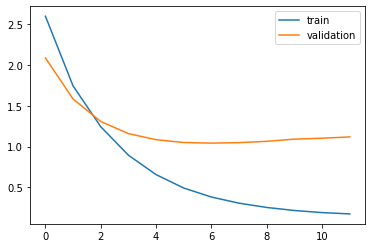

In [76]:
EPOCHES = 100
BS = 32

TF = False

# build NMT model
def define_model_simple(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
  input = x = Input(shape=(None,))
  x = Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True)(x)
  x, h, c = LSTM(units, return_state=True)(x)
  x = Dropout(0.5)(x)
  x = RepeatVector(out_timesteps)(x)
  x = LSTM(units, return_sequences=True)(x, initial_state = (h, c))
  # X = Dropout(0.5)(x)
  output = Dense(out_vocab, activation='softmax')(x)
  model = Model(input, output)
  return model, None, None

def define_model_tf(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
   # encoder
  encoder_inputs = Input(shape=(None,))
  encoder_embedding = Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True)
  encoder = encoder_embedding(encoder_inputs)
  _, state_h, state_c = LSTM(units, return_state=True)(encoder)
  encoder_states = [state_h, state_c]
  # decoder
  decoder_inputs = Input(shape=(None,))
  decoder_embedding = Embedding(out_vocab, units, input_length=out_timesteps, mask_zero=True)
  decoder = decoder_embedding(decoder_inputs)
  decoder_lstm = LSTM(units, return_sequences=True, return_state=True)
  decoder_outputs, _, _ = decoder_lstm(decoder, initial_state=encoder_states)
  decoder_dense = Dense(out_vocab, activation='softmax')
  decoder_outputs = decoder_dense(decoder_outputs)
  model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

  #inference model
  encoder_model = Model(encoder_inputs, encoder_states)

  decoder_state_input_h = Input(shape=(units,))
  decoder_state_input_c = Input(shape=(units,))
  decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
  decoder_outputs, h, c = decoder_lstm(decoder, initial_state=decoder_states_inputs)
  decoder_states = [h, c]
  decoder_outputs = decoder_dense(decoder_outputs)
  decoder_model = Model(
      [decoder_inputs] + decoder_states_inputs,
      [decoder_outputs] + decoder_states)
  
  return model, encoder_model, decoder_model

define_model = define_model_tf if TF else define_model_simple

model, encoder_model, decoder_model = define_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)
model.summary()
  
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

monitor = 'val_loss'
mode = 'min'
early_stop = EarlyStopping( patience=5, monitor=monitor, mode=mode, restore_best_weights=True)

if TF:
  data = [trainX, trainX_], trainY.reshape(*trainY.shape, 1)
  validation_data = [testX, testX_], testY.reshape(*testY.shape, 1)
else:
  data = trainX, trainY.reshape(*trainY.shape, 1)
  validation_data = testX, testY.reshape(*testY.shape, 1)

history = model.fit(*data, 
          epochs=EPOCHES, batch_size=BS, 
          validation_data=validation_data,
          callbacks=[early_stop], verbose=1)

# plot validation loss vs training loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [62]:
trainX[10], trainX_[10], trainY[10]
# eng_tokenizer.sequences_to_texts(trainX[10]), eng_tokenizer.sequences_to_texts(trainX_[10]), eng_tokenizer.sequences_to_texts(trainY[10])

(array([22, 75,  4, 76,  0,  0,  0,  0], dtype=int32),
 array([ 1, 26, 67, 37, 11,  0,  0,  0], dtype=int32),
 array([26, 67, 37, 11,  0,  0,  0,  0], dtype=int32))

In [75]:
def translate_sentence(input_seq):
  states_value = encoder_model.predict(input_seq, use_multiprocessing=True)
  target_seq = np.array([0] * eng_length)
  target_seq[0] = eng_tokenizer.word_index['<sos>']
  eos = eng_tokenizer.word_index['<eos>']
  output_sentence = []

  for _ in range(eng_length):
      output_tokens, h, c = decoder_model.predict([target_seq.reshape(1, -1)] + states_value, use_multiprocessing=True)
      idx = np.argmax(output_tokens[0, 0, :])

      if eos == idx:
          break

      if idx > 0:
          word = eng_tokenizer.index_word[idx]
          output_sentence.append(word)

      target_seq[0] = idx
      states_value = [h, c]

  return ' '.join(output_sentence)

a = np.random.choice(len(testX), 15)
x = testX[a]

if TF:
  translation = []
  for i in a:
    input_seq = testX[i]
    translation.append( translate_sentence(input_seq) )
else:
  pred_ohe = model.predict(x, use_multiprocessing=True)
  pred = np.argmax(pred_ohe, axis=2)
  translation = eng_tokenizer.sequences_to_texts(pred)

pred_df = pd.DataFrame({'actual' : eng_tokenizer.sequences_to_texts(testY[a]), 'predicted' : translation})
pred_df

,actual,predicted
0,ill send you a text,ill call you a
1,we cant fail again,we cant not so here
2,i thought i was alone,i thought i was alone
3,were afraid of death,we fear of
4,hes your father,hes your dad
5,everybody agrees,everybody agree agree
6,lets take a rest,lets go a break
7,tom is very tired,toms is very tired
8,they are not sisters,they arent twins
9,whose cats are these,who are are cats


# Simple CBOW